In [1]:
######### Package Imports #########################################################################
import os, warnings, copy, torch, ax
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from botorch.acquisition.logei import qLogNoisyExpectedImprovement
from ax.modelbridge.transforms.standardize_y import StandardizeY
from ax.modelbridge.transforms.unit_x import UnitX
from ax.modelbridge.transforms.remove_fixed import RemoveFixed
from ax.modelbridge.transforms.log import Log
from ax.core.base_trial import TrialStatus as T
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.plot.slice import plot_slice

from optimpv import *
from optimpv.axBOtorch.axBOtorchOptimizer import axBOtorchOptimizer
from optimpv.DDfits.HysteresisAgent import HysteresisAgent

import pySIMsalabim as sim
from pySIMsalabim.experiments.JV_steady_state import *
from pySIMsalabim.experiments.hysteresis import *

init_notebook_plotting()
warnings.filterwarnings('ignore') 
##############################################################################################
# Define the parameters to be fitted
params = []

mun = FitParam(name = 'l2.mu_n', value = 8e-5, bounds = [5e-5,1e-3], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$\mu_n$', unit='m$^2$ V$^{-1}$s$^{-1}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(mun)

mup = FitParam(name = 'l2.mu_p', value = 8e-5, bounds = [5e-5,1e-3], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$\mu_p$', unit='m$^2$ V$^{-1}$s$^{-1}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(mup)

bulk_tr = FitParam(name = 'l2.N_t_bulk', value = 3e20, bounds = [1e19,1e21], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$N_{T}$', unit='s', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(bulk_tr)

Nions = FitParam(name = 'l2.N_ions', value = 1e22, bounds = [1e20,5e22], type='range', values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$C_{ions}$', unit='m$^{-3}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(Nions)

muions = FitParam(name = 'l2.mu_ions', value = 5.7e-12, bounds = [1e-13,1e-11], type='range', values = None, start_value = None, log_scale = True, value_type = 'float', fscale = 1e-12, rescale = True, stepsize = None, display_name=r'$\mu_{ions}$', unit='m$^2$ V$^{-1}$s$^{-1}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(muions)

N_t_int_l1 = FitParam(name = 'l1.N_t_int', value = 5e12, bounds = [1e11,1e13], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$N_{T}^{int1}$', unit='m$^{-2}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(N_t_int_l1)

N_t_int_l2 = FitParam(name = 'l2.N_t_int', value = 4e12, bounds = [1e11,1e13], values = None, start_value = None, log_scale = True, value_type = 'float', fscale = None, rescale = False, stepsize = None, display_name=r'$N_{T}^{int2}$', unit='m$^{-2}$', axis_type = 'log', std = 0,encoding = None,force_log = False)
params.append(N_t_int_l2)


#original values
params_orig = copy.deepcopy(params)


[INFO 12-03 15:10:10] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 12-03 15:10:10] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


In [2]:

# session_path_simss = os.path.join('/home/lecorre/Desktop/pySIMsalabim/', 'SIMsalabim','SimSS')
# simss_device_parameters = os.path.join(session_path_simss, 'simulation_setup.txt')
session_path_zimt = os.path.join('/home/lecorre/Desktop/hysteresis_fits_Koster/', 'SIMsalabim','ZimT')
zimt_device_parameters = os.path.join(session_path_zimt, 'simulation_setup.txt')

# Set the JV parameters
direction = 1
G_frac = 1
Vmin = -1.1
Vmax = 0
steps = 200
# Gfracs = None

cmd_pars = []
for param in params:
    if param.name != 'l2.C_np_bulk' and param.name != 'offset_l2_l1.E_c' and param.name != 'offset_l2_l3.E_v' and param.name != 'Egap_l1.E_v' and param.name != 'offset_W_L.E_c' and param.name != 'l2.N_ions' and param.name != 'l2.mu_ions':
        cmd_pars.append({'par':param.name, 'val':str(param.value)})
    elif param.name == 'offset_l2_l1.E_c':
        cmd_pars.append({'par':'l1.E_c', 'val':str(3.9-param.value)})
        vv = 3.9-param.value
  
    elif param.name == 'l2.C_np_bulk':
        cmd_pars.append({'par':'l2.C_n_bulk', 'val':str(param.value)})
        cmd_pars.append({'par':'l2.C_p_bulk', 'val':str(param.value)})

    elif param.name == 'offset_l2_l3.E_v':
        cmd_pars.append({'par':'l3.E_v', 'val':str(5.53-param.value)})
    
    elif param.name == 'Egap_l1.E_v':
        cmd_pars.append({'par':'l1.E_v', 'val': str(vv+param.value)})
    
    elif param.name == 'offset_W_L.E_c':
        cmd_pars.append({'par':'W_L', 'val':str(vv-param.value)})

    elif param.name == 'l2.N_ions':
        cmd_pars.append({'par':'l2.N_cation', 'val':str(param.value)})
        cmd_pars.append({'par':'l2.N_anion', 'val':str(param.value)})

    elif param.name == 'l2.mu_ions':
        cmd_pars.append({'par':'l2.mu_cation', 'val':str(param.value)})
        cmd_pars.append({'par':'l2.mu_anion', 'val':str(param.value)})

t_ = time.time()
scan_speed1 = 0.23
UUID = str(uuid.uuid4())
# Run the JV simulation
ret, mess, rms = Hysteresis_JV(zimt_device_parameters, session_path_zimt, 0, scan_speed1, direction, G_frac, Vmin=Vmin, Vmax=Vmax, steps = steps, UUID = UUID, cmd_pars = cmd_pars)
print('scan_speed1 done in', time.time()-t_)
# Load the data
data = pd.read_csv(os.path.join(session_path_zimt, 'tj_'+UUID+'.dat'), sep=r'\s+')

# Extract the data
X1 = np.asarray(data['Vext'].values)
y1 = np.asarray(data['Jext'].values)

t_ = time.time()
scan_speed2 = 0.83
UUID = str(uuid.uuid4())
# Run the JV simulation
ret, mess, rms = Hysteresis_JV(zimt_device_parameters, session_path_zimt, 0, scan_speed2, direction, G_frac, Vmin=Vmin, Vmax=Vmax, steps = steps, UUID = UUID, cmd_pars = cmd_pars)
print('scan_speed2 done in', time.time()-t_)
# Load the data
data = pd.read_csv(os.path.join(session_path_zimt, 'tj_'+UUID+'.dat'), sep=r'\s+')

# Extract the data
X2 = np.asarray(data['Vext'].values)
y2 = np.asarray(data['Jext'].values)

t_ = time.time()
scan_speed3 = 496
UUID = str(uuid.uuid4())
# Run the JV simulation
ret, mess, rms = Hysteresis_JV(zimt_device_parameters, session_path_zimt, 0, scan_speed3, direction, G_frac, Vmin=Vmin, Vmax=Vmax, steps = steps, UUID = UUID, cmd_pars = cmd_pars)
print('scan_speed3 done in', time.time()-t_)
# Load the data
data = pd.read_csv(os.path.join(session_path_zimt, 'tj_'+UUID+'.dat'), sep=r'\s+')

# Extract the data
X3 = np.asarray(data['Vext'].values)
y3 = np.asarray(data['Jext'].values)

t_ = time.time()
scan_speed4 = 6400
UUID = str(uuid.uuid4())
# Run the JV simulation
ret, mess, rms = Hysteresis_JV(zimt_device_parameters, session_path_zimt, 0, scan_speed4, direction, G_frac, Vmin=Vmin, Vmax=Vmax, steps = steps, UUID = UUID, cmd_pars = cmd_pars)
print('scan_speed4 done in', time.time()-t_)
# Load the data
data = pd.read_csv(os.path.join(session_path_zimt, 'tj_'+UUID+'.dat'), sep=r'\s+')

# Extract the data
X4 = np.asarray(data['Vext'].values)
y4 = np.asarray(data['Jext'].values)





scan_speed1 done in 18.58783483505249
scan_speed2 done in 19.904018878936768
scan_speed3 done in 15.966983795166016
scan_speed4 done in 13.792680025100708


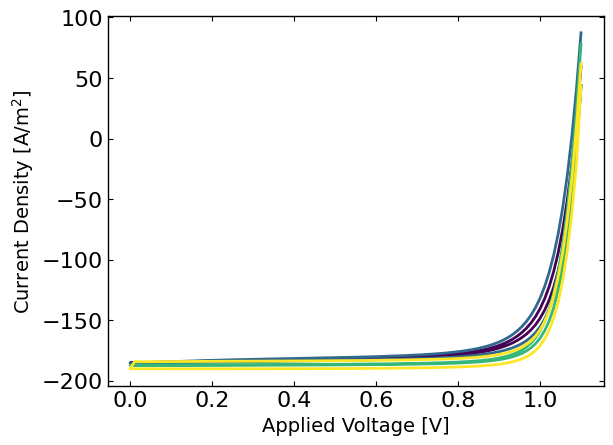

In [3]:
plt.figure()
viridis = plt.cm.get_cmap('viridis', 4)
plt.plot(-X1,-y1, color = viridis(0))
plt.plot(-X2,-y2, color = viridis(1))
plt.plot(-X3,-y3, color = viridis(2))
plt.plot(-X4,-y4, color = viridis(3))

plt.xlabel('Applied Voltage [V]')
plt.ylabel('Current Density [A/m$^2$]')
plt.show()


In [4]:
# Define the agents
metric = 'rmsre'
loss = 'log10'

hyst1 = HysteresisAgent(params, X1, y1, session_path_zimt, Vmin, Vmax, scan_speed1, steps, direction, G_frac=1, simulation_setup=zimt_device_parameters, metric=[metric], loss=[loss], threshold= [-0.5],minimize=[True], name='Hyst1')

hyst2 = HysteresisAgent(params, X2, y2, session_path_zimt, Vmin, Vmax, scan_speed2, steps, direction, G_frac=1, simulation_setup=zimt_device_parameters, metric=[metric], loss=[loss], threshold= [-0.5],minimize=[True], name='Hyst2')

hyst3 = HysteresisAgent(params, X3, y3, session_path_zimt, Vmin, Vmax, scan_speed3, steps, direction, G_frac=1, simulation_setup=zimt_device_parameters, metric=[metric], loss=[loss], threshold= [-0.5],minimize=[True], name='Hyst3')

hyst4 = HysteresisAgent(params, X4, y4, session_path_zimt, Vmin, Vmax, scan_speed4, steps, direction, G_frac=1, simulation_setup=zimt_device_parameters, metric=[metric], loss=[loss], threshold= [-0.5],minimize=[True], name='Hyst4')

In [5]:
# Define the model kwargs
model_kwargs_list = [{'torch_device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),'torch_dtype': torch.double},{'torch_device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),'torch_dtype': torch.double,'botorch_acqf_class':qLogNoisyExpectedImprovement,'transforms':[RemoveFixed, Log,UnitX, StandardizeY]}]

# Define the optimizer
optimizer = axBOtorchOptimizer(params = params, agents = [hyst1, hyst2, hyst3, hyst4 ], models = ['SOBOL','BOTORCH_MODULAR'],n_batches = [1,30], batch_size = [10,2], ax_client = None,  max_parallelism = -1, model_kwargs_list = None, model_gen_kwargs_list = None, name = 'ax_opti', parallel_agents = True)



In [6]:
optimizer.optimize()

[INFO 12-03 15:11:18] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-03 15:11:18] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='l2.mu_n', parameter_type=FLOAT, range=[5e-05, 0.001], log_scale=True), RangeParameter(name='l2.mu_p', parameter_type=FLOAT, range=[5e-05, 0.001], log_scale=True), RangeParameter(name='l2.N_t_bulk', parameter_type=FLOAT, range=[1e+19, 1e+21], log_scale=True), RangeParameter(name='l2.N_ions', parameter_type=FLOAT, range=[1e+20, 5e+22], log_scale=True), RangeParameter(name='l2.mu_ions', parameter_type=FLOAT, range=[0.1, 10.0], log_scale=True), RangeParameter(name='l1.N_t_int', parameter_type=FLOAT, range=[100000000000.0, 10000000000000.0], log_scale=True), RangeParameter(name='l2.N_t_int', parameter_type=FLOAT, range=[100000000000.0, 10000000000000.0]

Running 10 parameter points with 4 agents
Error in running SIMsalabim: 


[INFO 12-03 15:12:00] ax.service.ax_client: Completed trial 0 with data: {'Hyst1_JV_rmsre': (0.532916, None), 'Hyst2_JV_rmsre': (0.750853, None), 'Hyst3_JV_rmsre': (0.223477, None), 'Hyst4_JV_rmsre': (0.11691, None)}.
[INFO 12-03 15:12:00] ax.service.ax_client: Completed trial 1 with data: {'Hyst1_JV_rmsre': (-0.956545, None), 'Hyst2_JV_rmsre': (-0.301476, None), 'Hyst3_JV_rmsre': (-0.957508, None), 'Hyst4_JV_rmsre': (-0.901296, None)}.
[INFO 12-03 15:12:00] ax.service.ax_client: Completed trial 2 with data: {'Hyst1_JV_rmsre': (0.66685, None), 'Hyst2_JV_rmsre': (0.746486, None), 'Hyst3_JV_rmsre': (0.353451, None), 'Hyst4_JV_rmsre': (0.279503, None)}.
[INFO 12-03 15:12:00] ax.service.ax_client: Completed trial 3 with data: {'Hyst1_JV_rmsre': (0.534952, None), 'Hyst2_JV_rmsre': (0.692333, None), 'Hyst3_JV_rmsre': (0.224957, None), 'Hyst4_JV_rmsre': (0.138536, None)}.
[INFO 12-03 15:12:00] ax.service.ax_client: Registered failure of trial 4.
[INFO 12-03 15:12:00] ax.service.ax_client: Com

Running 2 parameter points with 4 agents
Error in running SIMsalabim: 


[INFO 12-03 15:12:30] ax.service.ax_client: Completed trial 10 with data: {'Hyst1_JV_rmsre': (-0.166069, None), 'Hyst2_JV_rmsre': (0.122659, None), 'Hyst3_JV_rmsre': (-0.503073, None), 'Hyst4_JV_rmsre': (-0.571731, None)}.
[INFO 12-03 15:12:30] ax.service.ax_client: Registered failure of trial 11.
[INFO 12-03 15:12:32] ax.service.ax_client: Generated new trial 12 with parameters {'l2.mu_n': 0.000639, 'l2.mu_p': 0.000149, 'l2.N_t_bulk': 5.2914868587292505e+20, 'l2.N_ions': 2.9243664163404256e+21, 'l2.mu_ions': 3.027926, 'l1.N_t_int': 2865276075831.6694, 'l2.N_t_int': 1613520274828.3518} using model BoTorch.
[INFO 12-03 15:12:35] ax.service.ax_client: Generated new trial 13 with parameters {'l2.mu_n': 0.000664, 'l2.mu_p': 0.000313, 'l2.N_t_bulk': 3.417454003458989e+20, 'l2.N_ions': 2.735742367481675e+21, 'l2.mu_ions': 7.552535, 'l1.N_t_int': 2694083116563.887, 'l2.N_t_int': 622191035716.6339} using model BoTorch.


Running 2 parameter points with 4 agents
Error in running SIMsalabim: 


[INFO 12-03 15:12:57] ax.service.ax_client: Completed trial 12 with data: {'Hyst1_JV_rmsre': (-1.314254, None), 'Hyst2_JV_rmsre': (-0.672981, None), 'Hyst3_JV_rmsre': (-1.076815, None), 'Hyst4_JV_rmsre': (-1.117485, None)}.
[INFO 12-03 15:12:57] ax.service.ax_client: Registered failure of trial 13.
[INFO 12-03 15:12:59] ax.service.ax_client: Generated new trial 14 with parameters {'l2.mu_n': 0.000714, 'l2.mu_p': 0.000275, 'l2.N_t_bulk': 6.165597105811871e+20, 'l2.N_ions': 2.3715029198892423e+21, 'l2.mu_ions': 2.426347, 'l1.N_t_int': 3108267801769.285, 'l2.N_t_int': 721370910419.1554} using model BoTorch.
[INFO 12-03 15:13:04] ax.service.ax_client: Generated new trial 15 with parameters {'l2.mu_n': 0.000699, 'l2.mu_p': 0.000139, 'l2.N_t_bulk': 3.928653621262432e+20, 'l2.N_ions': 2.6657889895410235e+21, 'l2.mu_ions': 2.213145, 'l1.N_t_int': 7067828276593.333, 'l2.N_t_int': 1724642327395.12} using model BoTorch.


Running 2 parameter points with 4 agents


[INFO 12-03 15:13:26] ax.service.ax_client: Completed trial 14 with data: {'Hyst1_JV_rmsre': (-0.676414, None), 'Hyst2_JV_rmsre': (-0.787985, None), 'Hyst3_JV_rmsre': (-0.908101, None), 'Hyst4_JV_rmsre': (-0.858892, None)}.
[INFO 12-03 15:13:26] ax.service.ax_client: Completed trial 15 with data: {'Hyst1_JV_rmsre': (0.58575, None), 'Hyst2_JV_rmsre': (0.770301, None), 'Hyst3_JV_rmsre': (0.264989, None), 'Hyst4_JV_rmsre': (0.20265, None)}.
[INFO 12-03 15:13:30] ax.service.ax_client: Generated new trial 16 with parameters {'l2.mu_n': 0.000574, 'l2.mu_p': 0.00014, 'l2.N_t_bulk': 3.649906619647383e+20, 'l2.N_ions': 3.683649231553949e+21, 'l2.mu_ions': 3.159976, 'l1.N_t_int': 2575314546761.6895, 'l2.N_t_int': 944779251306.9386} using model BoTorch.
[INFO 12-03 15:13:40] ax.service.ax_client: Generated new trial 17 with parameters {'l2.mu_n': 0.000395, 'l2.mu_p': 0.000157, 'l2.N_t_bulk': 5.813893906208242e+20, 'l2.N_ions': 3.4376019131595867e+21, 'l2.mu_ions': 3.429819, 'l1.N_t_int': 26064779

Running 2 parameter points with 4 agents


[INFO 12-03 15:14:02] ax.service.ax_client: Completed trial 16 with data: {'Hyst1_JV_rmsre': (-0.160518, None), 'Hyst2_JV_rmsre': (0.083388, None), 'Hyst3_JV_rmsre': (-0.446188, None), 'Hyst4_JV_rmsre': (-0.622511, None)}.
[INFO 12-03 15:14:02] ax.service.ax_client: Completed trial 17 with data: {'Hyst1_JV_rmsre': (-0.461128, None), 'Hyst2_JV_rmsre': (-0.145837, None), 'Hyst3_JV_rmsre': (-0.708561, None), 'Hyst4_JV_rmsre': (-0.966198, None)}.
[INFO 12-03 15:14:13] ax.service.ax_client: Generated new trial 18 with parameters {'l2.mu_n': 0.000727, 'l2.mu_p': 0.000147, 'l2.N_t_bulk': 6.3802113052217e+20, 'l2.N_ions': 2.167691276683934e+21, 'l2.mu_ions': 2.913296, 'l1.N_t_int': 2892824078748.586, 'l2.N_t_int': 2222978658544.8926} using model BoTorch.
[INFO 12-03 15:14:36] ax.service.ax_client: Generated new trial 19 with parameters {'l2.mu_n': 0.000726, 'l2.mu_p': 0.000168, 'l2.N_t_bulk': 6.31063409569782e+20, 'l2.N_ions': 1.7294365201477838e+21, 'l2.mu_ions': 6.403844, 'l1.N_t_int': 29075

Running 2 parameter points with 4 agents


[INFO 12-03 15:14:58] ax.service.ax_client: Completed trial 18 with data: {'Hyst1_JV_rmsre': (-0.319868, None), 'Hyst2_JV_rmsre': (-0.38368, None), 'Hyst3_JV_rmsre': (-0.622364, None), 'Hyst4_JV_rmsre': (-0.597737, None)}.
[INFO 12-03 15:14:58] ax.service.ax_client: Completed trial 19 with data: {'Hyst1_JV_rmsre': (-0.239462, None), 'Hyst2_JV_rmsre': (-0.366836, None), 'Hyst3_JV_rmsre': (-0.542207, None), 'Hyst4_JV_rmsre': (-0.52557, None)}.
[INFO 12-03 15:15:11] ax.service.ax_client: Generated new trial 20 with parameters {'l2.mu_n': 0.000912, 'l2.mu_p': 0.000381, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 3.003114718437727e+21, 'l2.mu_ions': 1.501371, 'l1.N_t_int': 2992139869810.2446, 'l2.N_t_int': 1030670768745.267} using model BoTorch.
[INFO 12-03 15:15:26] ax.service.ax_client: Generated new trial 21 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000231, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 3.040089270660236e+21, 'l2.mu_ions': 0.49737, 'l1.N_t_int': 2992110747639.1465, 'l2.N_t_int': 106751

Running 2 parameter points with 4 agents


[INFO 12-03 15:15:49] ax.service.ax_client: Completed trial 20 with data: {'Hyst1_JV_rmsre': (-1.285134, None), 'Hyst2_JV_rmsre': (-0.465815, None), 'Hyst3_JV_rmsre': (-1.018294, None), 'Hyst4_JV_rmsre': (-1.261476, None)}.
[INFO 12-03 15:15:49] ax.service.ax_client: Completed trial 21 with data: {'Hyst1_JV_rmsre': (-0.42281, None), 'Hyst2_JV_rmsre': (0.09714, None), 'Hyst3_JV_rmsre': (-0.822636, None), 'Hyst4_JV_rmsre': (-0.806942, None)}.
[INFO 12-03 15:16:01] ax.service.ax_client: Generated new trial 22 with parameters {'l2.mu_n': 0.000652, 'l2.mu_p': 0.000609, 'l2.N_t_bulk': 7.36875413106064e+20, 'l2.N_ions': 7.227138979594113e+21, 'l2.mu_ions': 4.281443, 'l1.N_t_int': 3037231564775.305, 'l2.N_t_int': 940694333685.8931} using model BoTorch.
[INFO 12-03 15:16:16] ax.service.ax_client: Generated new trial 23 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000706, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 9.492829335584323e+21, 'l2.mu_ions': 5.483351, 'l1.N_t_int': 3038844991771.1064, 'l2.N_

Running 2 parameter points with 4 agents


[INFO 12-03 15:16:42] ax.service.ax_client: Completed trial 22 with data: {'Hyst1_JV_rmsre': (0.142139, None), 'Hyst2_JV_rmsre': (0.324897, None), 'Hyst3_JV_rmsre': (-0.161621, None), 'Hyst4_JV_rmsre': (-0.266197, None)}.
[INFO 12-03 15:16:42] ax.service.ax_client: Completed trial 23 with data: {'Hyst1_JV_rmsre': (0.220053, None), 'Hyst2_JV_rmsre': (0.422683, None), 'Hyst3_JV_rmsre': (-0.09091, None), 'Hyst4_JV_rmsre': (-0.181242, None)}.
[INFO 12-03 15:17:02] ax.service.ax_client: Generated new trial 24 with parameters {'l2.mu_n': 0.000755, 'l2.mu_p': 0.000263, 'l2.N_t_bulk': 9.098347485299674e+20, 'l2.N_ions': 2.8365104918889486e+21, 'l2.mu_ions': 3.233503, 'l1.N_t_int': 3061412096367.5464, 'l2.N_t_int': 1453146999604.3032} using model BoTorch.
[INFO 12-03 15:17:27] ax.service.ax_client: Generated new trial 25 with parameters {'l2.mu_n': 0.000626, 'l2.mu_p': 0.000588, 'l2.N_t_bulk': 5.869727852822196e+20, 'l2.N_ions': 2.8091923852312073e+21, 'l2.mu_ions': 2.866294, 'l1.N_t_int': 3047

Running 2 parameter points with 4 agents


[INFO 12-03 15:17:50] ax.service.ax_client: Completed trial 24 with data: {'Hyst1_JV_rmsre': (-0.555387, None), 'Hyst2_JV_rmsre': (-0.619701, None), 'Hyst3_JV_rmsre': (-0.831478, None), 'Hyst4_JV_rmsre': (-0.793555, None)}.
[INFO 12-03 15:17:50] ax.service.ax_client: Completed trial 25 with data: {'Hyst1_JV_rmsre': (-0.43977, None), 'Hyst2_JV_rmsre': (-0.127474, None), 'Hyst3_JV_rmsre': (-0.676208, None), 'Hyst4_JV_rmsre': (-0.962493, None)}.
[INFO 12-03 15:18:20] ax.service.ax_client: Generated new trial 26 with parameters {'l2.mu_n': 0.000725, 'l2.mu_p': 0.000181, 'l2.N_t_bulk': 7.257960874516185e+20, 'l2.N_ions': 2.825154563528514e+21, 'l2.mu_ions': 1.71969, 'l1.N_t_int': 3007917722247.481, 'l2.N_t_int': 944457641543.6698} using model BoTorch.
[INFO 12-03 15:18:39] ax.service.ax_client: Generated new trial 27 with parameters {'l2.mu_n': 0.000459, 'l2.mu_p': 0.000117, 'l2.N_t_bulk': 4.7462263863598816e+20, 'l2.N_ions': 2.855545112882711e+21, 'l2.mu_ions': 2.424658, 'l1.N_t_int': 3002

Running 2 parameter points with 4 agents


[INFO 12-03 15:19:02] ax.service.ax_client: Completed trial 26 with data: {'Hyst1_JV_rmsre': (-0.536419, None), 'Hyst2_JV_rmsre': (-0.262598, None), 'Hyst3_JV_rmsre': (-0.820372, None), 'Hyst4_JV_rmsre': (-0.783917, None)}.
[INFO 12-03 15:19:02] ax.service.ax_client: Completed trial 27 with data: {'Hyst1_JV_rmsre': (-0.619879, None), 'Hyst2_JV_rmsre': (-0.545377, None), 'Hyst3_JV_rmsre': (-0.875032, None), 'Hyst4_JV_rmsre': (-0.824421, None)}.
[INFO 12-03 15:19:25] ax.service.ax_client: Generated new trial 28 with parameters {'l2.mu_n': 0.000729, 'l2.mu_p': 0.000167, 'l2.N_t_bulk': 4.906771861735734e+20, 'l2.N_ions': 3.281462157501841e+21, 'l2.mu_ions': 5.907523, 'l1.N_t_int': 2937947503331.775, 'l2.N_t_int': 1532182236675.9138} using model BoTorch.
[INFO 12-03 15:19:47] ax.service.ax_client: Generated new trial 29 with parameters {'l2.mu_n': 0.000837, 'l2.mu_p': 0.000318, 'l2.N_t_bulk': 5.31086629135472e+20, 'l2.N_ions': 2.958835913206819e+21, 'l2.mu_ions': 3.958974, 'l1.N_t_int': 302

Running 2 parameter points with 4 agents


[INFO 12-03 15:20:09] ax.service.ax_client: Completed trial 28 with data: {'Hyst1_JV_rmsre': (-0.799918, None), 'Hyst2_JV_rmsre': (-0.092486, None), 'Hyst3_JV_rmsre': (-1.002084, None), 'Hyst4_JV_rmsre': (-1.330931, None)}.
[INFO 12-03 15:20:09] ax.service.ax_client: Completed trial 29 with data: {'Hyst1_JV_rmsre': (-0.610494, None), 'Hyst2_JV_rmsre': (-0.109006, None), 'Hyst3_JV_rmsre': (-0.822179, None), 'Hyst4_JV_rmsre': (-1.193288, None)}.
[INFO 12-03 15:20:38] ax.service.ax_client: Generated new trial 30 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000262, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 2.6829029339003754e+21, 'l2.mu_ions': 2.317515, 'l1.N_t_int': 2924853635814.1143, 'l2.N_t_int': 1339704746168.655} using model BoTorch.
[INFO 12-03 15:20:56] ax.modelbridge.base: Untransformed parameter 4.9999999999999996e-05 less than lower bound 5e-05, clamping
[INFO 12-03 15:20:56] ax.service.ax_client: Generated new trial 31 with parameters {'l2.mu_n': 0.000954, 'l2.mu_p': 5e-05, 'l2.N_t

Running 2 parameter points with 4 agents


[INFO 12-03 15:21:18] ax.service.ax_client: Completed trial 30 with data: {'Hyst1_JV_rmsre': (-0.54973, None), 'Hyst2_JV_rmsre': (-0.442216, None), 'Hyst3_JV_rmsre': (-0.823335, None), 'Hyst4_JV_rmsre': (-0.785845, None)}.
[INFO 12-03 15:21:18] ax.service.ax_client: Completed trial 31 with data: {'Hyst1_JV_rmsre': (-0.418842, None), 'Hyst2_JV_rmsre': (-0.402759, None), 'Hyst3_JV_rmsre': (-0.652798, None), 'Hyst4_JV_rmsre': (-0.628751, None)}.
[INFO 12-03 15:21:55] ax.service.ax_client: Generated new trial 32 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000243, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 3.081044580209839e+21, 'l2.mu_ions': 2.62858, 'l1.N_t_int': 3196288090603.9277, 'l2.N_t_int': 441242608600.8238} using model BoTorch.
[INFO 12-03 15:22:27] ax.service.ax_client: Generated new trial 33 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000112, 'l2.N_t_bulk': 5.0398267780903816e+20, 'l2.N_ions': 3.121910430889887e+21, 'l2.mu_ions': 2.53663, 'l1.N_t_int': 2836053203740.678, 'l2.N_t

Running 2 parameter points with 4 agents


[INFO 12-03 15:22:51] ax.service.ax_client: Completed trial 32 with data: {'Hyst1_JV_rmsre': (-0.392371, None), 'Hyst2_JV_rmsre': (-0.227893, None), 'Hyst3_JV_rmsre': (-0.701051, None), 'Hyst4_JV_rmsre': (-0.683132, None)}.
[INFO 12-03 15:22:51] ax.service.ax_client: Completed trial 33 with data: {'Hyst1_JV_rmsre': (-0.729975, None), 'Hyst2_JV_rmsre': (-0.413097, None), 'Hyst3_JV_rmsre': (-0.94863, None), 'Hyst4_JV_rmsre': (-0.883248, None)}.
[INFO 12-03 15:23:21] ax.service.ax_client: Generated new trial 34 with parameters {'l2.mu_n': 0.000498, 'l2.mu_p': 0.000185, 'l2.N_t_bulk': 4.871690331121104e+20, 'l2.N_ions': 2.4974340197929037e+21, 'l2.mu_ions': 2.63046, 'l1.N_t_int': 2827383393861.9595, 'l2.N_t_int': 3709077113150.702} using model BoTorch.
[INFO 12-03 15:23:59] ax.service.ax_client: Generated new trial 35 with parameters {'l2.mu_n': 0.000289, 'l2.mu_p': 0.000451, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 2.627197515930531e+21, 'l2.mu_ions': 2.413431, 'l1.N_t_int': 2921864065983.4043,

Running 2 parameter points with 4 agents


[INFO 12-03 15:24:21] ax.service.ax_client: Completed trial 34 with data: {'Hyst1_JV_rmsre': (-1.24698, None), 'Hyst2_JV_rmsre': (-0.832404, None), 'Hyst3_JV_rmsre': (-1.055586, None), 'Hyst4_JV_rmsre': (-1.101236, None)}.
[INFO 12-03 15:24:21] ax.service.ax_client: Completed trial 35 with data: {'Hyst1_JV_rmsre': (-1.079084, None), 'Hyst2_JV_rmsre': (-0.839485, None), 'Hyst3_JV_rmsre': (-1.028207, None), 'Hyst4_JV_rmsre': (-1.131099, None)}.
[INFO 12-03 15:24:55] ax.service.ax_client: Generated new trial 36 with parameters {'l2.mu_n': 0.000319, 'l2.mu_p': 0.000229, 'l2.N_t_bulk': 4.7984171839067836e+20, 'l2.N_ions': 2.6175212334081764e+21, 'l2.mu_ions': 3.141384, 'l1.N_t_int': 2876249357343.5625, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:25:45] ax.service.ax_client: Generated new trial 37 with parameters {'l2.mu_n': 0.000283, 'l2.mu_p': 0.000282, 'l2.N_t_bulk': 5.545554298540674e+20, 'l2.N_ions': 2.5384147629806484e+21, 'l2.mu_ions': 2.604099, 'l1.N_t_int': 2

Running 2 parameter points with 4 agents


[INFO 12-03 15:26:06] ax.service.ax_client: Completed trial 36 with data: {'Hyst1_JV_rmsre': (-1.015159, None), 'Hyst2_JV_rmsre': (-1.066241, None), 'Hyst3_JV_rmsre': (-1.045608, None), 'Hyst4_JV_rmsre': (-1.059236, None)}.
[INFO 12-03 15:26:07] ax.service.ax_client: Completed trial 37 with data: {'Hyst1_JV_rmsre': (-0.860485, None), 'Hyst2_JV_rmsre': (-0.432565, None), 'Hyst3_JV_rmsre': (-0.929085, None), 'Hyst4_JV_rmsre': (-1.390514, None)}.
[INFO 12-03 15:27:05] ax.service.ax_client: Generated new trial 38 with parameters {'l2.mu_n': 0.000137, 'l2.mu_p': 0.00029, 'l2.N_t_bulk': 5.814088011272007e+20, 'l2.N_ions': 2.510146402047123e+21, 'l2.mu_ions': 2.683238, 'l1.N_t_int': 2793726259585.4873, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:28:11] ax.service.ax_client: Generated new trial 39 with parameters {'l2.mu_n': 0.00057, 'l2.mu_p': 0.000513, 'l2.N_t_bulk': 8.690255644275482e+20, 'l2.N_ions': 2.516667510781467e+21, 'l2.mu_ions': 2.504211, 'l1.N_t_int': 28368

Running 2 parameter points with 4 agents


[INFO 12-03 15:28:32] ax.service.ax_client: Completed trial 38 with data: {'Hyst1_JV_rmsre': (-1.325872, None), 'Hyst2_JV_rmsre': (-1.107137, None), 'Hyst3_JV_rmsre': (-1.041788, None), 'Hyst4_JV_rmsre': (-1.238712, None)}.
[INFO 12-03 15:28:32] ax.service.ax_client: Completed trial 39 with data: {'Hyst1_JV_rmsre': (-1.114324, None), 'Hyst2_JV_rmsre': (-0.904397, None), 'Hyst3_JV_rmsre': (-0.988906, None), 'Hyst4_JV_rmsre': (-1.389017, None)}.
[INFO 12-03 15:29:12] ax.service.ax_client: Generated new trial 40 with parameters {'l2.mu_n': 0.00012, 'l2.mu_p': 0.000483, 'l2.N_t_bulk': 7.79208810279002e+20, 'l2.N_ions': 2.5772097565842027e+21, 'l2.mu_ions': 1.45285, 'l1.N_t_int': 2707968042240.947, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:29:44] ax.service.ax_client: Generated new trial 41 with parameters {'l2.mu_n': 5.4e-05, 'l2.mu_p': 0.000452, 'l2.N_t_bulk': 7.400240486641146e+20, 'l2.N_ions': 2.376359090064803e+21, 'l2.mu_ions': 2.527998, 'l1.N_t_int': 2683769

Running 2 parameter points with 4 agents


[INFO 12-03 15:30:05] ax.service.ax_client: Completed trial 40 with data: {'Hyst1_JV_rmsre': (-0.744296, None), 'Hyst2_JV_rmsre': (-0.563828, None), 'Hyst3_JV_rmsre': (-0.849501, None), 'Hyst4_JV_rmsre': (-1.183677, None)}.
[INFO 12-03 15:30:05] ax.service.ax_client: Completed trial 41 with data: {'Hyst1_JV_rmsre': (-1.015416, None), 'Hyst2_JV_rmsre': (-1.029852, None), 'Hyst3_JV_rmsre': (-0.957362, None), 'Hyst4_JV_rmsre': (-1.12724, None)}.
[INFO 12-03 15:30:39] ax.service.ax_client: Generated new trial 42 with parameters {'l2.mu_n': 0.00029, 'l2.mu_p': 0.000382, 'l2.N_t_bulk': 6.443103116263358e+20, 'l2.N_ions': 2.596791824247068e+21, 'l2.mu_ions': 4.463627, 'l1.N_t_int': 2765196357225.9233, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:31:07] ax.modelbridge.base: Untransformed parameter 4.9999999999999996e-05 less than lower bound 5e-05, clamping
[INFO 12-03 15:31:07] ax.service.ax_client: Generated new trial 43 with parameters {'l2.mu_n': 5e-05, 'l2.mu_p': 0.

Running 2 parameter points with 4 agents


[INFO 12-03 15:31:28] ax.service.ax_client: Completed trial 42 with data: {'Hyst1_JV_rmsre': (-0.780792, None), 'Hyst2_JV_rmsre': (-0.199878, None), 'Hyst3_JV_rmsre': (-0.940563, None), 'Hyst4_JV_rmsre': (-1.372967, None)}.
[INFO 12-03 15:31:28] ax.service.ax_client: Completed trial 43 with data: {'Hyst1_JV_rmsre': (-0.796859, None), 'Hyst2_JV_rmsre': (-0.822921, None), 'Hyst3_JV_rmsre': (-0.914305, None), 'Hyst4_JV_rmsre': (-0.999757, None)}.
[INFO 12-03 15:32:14] ax.service.ax_client: Generated new trial 44 with parameters {'l2.mu_n': 8.5e-05, 'l2.mu_p': 0.000329, 'l2.N_t_bulk': 6.303620436104677e+20, 'l2.N_ions': 2.3056467384551699e+21, 'l2.mu_ions': 2.264019, 'l1.N_t_int': 2891997033673.38, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:33:08] ax.service.ax_client: Generated new trial 45 with parameters {'l2.mu_n': 0.000867, 'l2.mu_p': 0.000384, 'l2.N_t_bulk': 6.72637532393285e+20, 'l2.N_ions': 2.495305025103159e+21, 'l2.mu_ions': 2.093661, 'l1.N_t_int': 281649

Running 2 parameter points with 4 agents


[INFO 12-03 15:33:30] ax.service.ax_client: Completed trial 44 with data: {'Hyst1_JV_rmsre': (-0.755703, None), 'Hyst2_JV_rmsre': (-0.459014, None), 'Hyst3_JV_rmsre': (-0.909498, None), 'Hyst4_JV_rmsre': (-0.993903, None)}.
[INFO 12-03 15:33:30] ax.service.ax_client: Completed trial 45 with data: {'Hyst1_JV_rmsre': (-1.215277, None), 'Hyst2_JV_rmsre': (-1.20797, None), 'Hyst3_JV_rmsre': (-0.992856, None), 'Hyst4_JV_rmsre': (-1.307469, None)}.
[INFO 12-03 15:34:19] ax.service.ax_client: Generated new trial 46 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000657, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 2.291456471575517e+21, 'l2.mu_ions': 2.173993, 'l1.N_t_int': 2876441149334.191, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:35:00] ax.service.ax_client: Generated new trial 47 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000302, 'l2.N_t_bulk': 5.516223276396192e+20, 'l2.N_ions': 2.2715864327579954e+21, 'l2.mu_ions': 2.215659, 'l1.N_t_int': 2673364669550.177, 'l2.N_t

Running 2 parameter points with 4 agents


[INFO 12-03 15:35:22] ax.service.ax_client: Completed trial 46 with data: {'Hyst1_JV_rmsre': (-1.439623, None), 'Hyst2_JV_rmsre': (-1.347535, None), 'Hyst3_JV_rmsre': (-1.026407, None), 'Hyst4_JV_rmsre': (-1.213065, None)}.
[INFO 12-03 15:35:22] ax.service.ax_client: Completed trial 47 with data: {'Hyst1_JV_rmsre': (-1.1072, None), 'Hyst2_JV_rmsre': (-0.995157, None), 'Hyst3_JV_rmsre': (-0.984882, None), 'Hyst4_JV_rmsre': (-1.268045, None)}.
[INFO 12-03 15:36:19] ax.service.ax_client: Generated new trial 48 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000525, 'l2.N_t_bulk': 7.648747489099018e+20, 'l2.N_ions': 2.0006004797404713e+21, 'l2.mu_ions': 2.007817, 'l1.N_t_int': 2762089492062.1562, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:37:28] ax.service.ax_client: Generated new trial 49 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000505, 'l2.N_t_bulk': 7.627294241008056e+20, 'l2.N_ions': 2.6704724828404187e+21, 'l2.mu_ions': 2.317741, 'l1.N_t_int': 277218162

Running 2 parameter points with 4 agents


[INFO 12-03 15:37:50] ax.service.ax_client: Completed trial 48 with data: {'Hyst1_JV_rmsre': (-1.393242, None), 'Hyst2_JV_rmsre': (-0.943648, None), 'Hyst3_JV_rmsre': (-1.019151, None), 'Hyst4_JV_rmsre': (-1.183017, None)}.
[INFO 12-03 15:37:50] ax.service.ax_client: Completed trial 49 with data: {'Hyst1_JV_rmsre': (-0.597457, None), 'Hyst2_JV_rmsre': (-0.522934, None), 'Hyst3_JV_rmsre': (-0.777771, None), 'Hyst4_JV_rmsre': (-1.14265, None)}.
[INFO 12-03 15:38:34] ax.service.ax_client: Generated new trial 50 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000341, 'l2.N_t_bulk': 5.001050935063493e+20, 'l2.N_ions': 1.9455413289838683e+21, 'l2.mu_ions': 1.673808, 'l1.N_t_int': 2751450241198.2095, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:39:41] ax.service.ax_client: Generated new trial 51 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000585, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 2.066203098025263e+21, 'l2.mu_ions': 2.046891, 'l1.N_t_int': 3003928241026.9424, 'l2.N

Running 2 parameter points with 4 agents


[INFO 12-03 15:40:03] ax.service.ax_client: Completed trial 50 with data: {'Hyst1_JV_rmsre': (-1.277342, None), 'Hyst2_JV_rmsre': (-0.884863, None), 'Hyst3_JV_rmsre': (-1.023512, None), 'Hyst4_JV_rmsre': (-1.083652, None)}.
[INFO 12-03 15:40:03] ax.service.ax_client: Completed trial 51 with data: {'Hyst1_JV_rmsre': (-0.535085, None), 'Hyst2_JV_rmsre': (-0.42592, None), 'Hyst3_JV_rmsre': (-0.811327, None), 'Hyst4_JV_rmsre': (-0.776982, None)}.
[INFO 12-03 15:41:12] ax.service.ax_client: Generated new trial 52 with parameters {'l2.mu_n': 0.00051, 'l2.mu_p': 0.000545, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 2.0387192499368624e+21, 'l2.mu_ions': 2.302604, 'l1.N_t_int': 2638848510002.984, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:42:47] ax.service.ax_client: Generated new trial 53 with parameters {'l2.mu_n': 0.000251, 'l2.mu_p': 0.000322, 'l2.N_t_bulk': 6.056536133552476e+20, 'l2.N_ions': 2.0389055293077908e+21, 'l2.mu_ions': 1.726346, 'l1.N_t_int': 2602425435579.3076, 

Running 2 parameter points with 4 agents


[INFO 12-03 15:43:08] ax.service.ax_client: Completed trial 52 with data: {'Hyst1_JV_rmsre': (-1.386682, None), 'Hyst2_JV_rmsre': (-0.724511, None), 'Hyst3_JV_rmsre': (-1.02342, None), 'Hyst4_JV_rmsre': (-1.233458, None)}.
[INFO 12-03 15:43:08] ax.service.ax_client: Completed trial 53 with data: {'Hyst1_JV_rmsre': (-1.524457, None), 'Hyst2_JV_rmsre': (-0.956183, None), 'Hyst3_JV_rmsre': (-1.012052, None), 'Hyst4_JV_rmsre': (-1.252178, None)}.
[INFO 12-03 15:44:33] ax.service.ax_client: Generated new trial 54 with parameters {'l2.mu_n': 0.000552, 'l2.mu_p': 0.000375, 'l2.N_t_bulk': 7.859122947509702e+20, 'l2.N_ions': 1.9975006657310595e+21, 'l2.mu_ions': 2.003684, 'l1.N_t_int': 2426243719861.1963, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:45:46] ax.service.ax_client: Generated new trial 55 with parameters {'l2.mu_n': 0.000261, 'l2.mu_p': 0.000507, 'l2.N_t_bulk': 6.87141063299651e+20, 'l2.N_ions': 1.791834968329934e+21, 'l2.mu_ions': 2.056236, 'l1.N_t_int': 2566

Running 2 parameter points with 4 agents


[INFO 12-03 15:46:07] ax.service.ax_client: Completed trial 54 with data: {'Hyst1_JV_rmsre': (-0.854883, None), 'Hyst2_JV_rmsre': (-0.562999, None), 'Hyst3_JV_rmsre': (-0.910349, None), 'Hyst4_JV_rmsre': (-1.279278, None)}.
[INFO 12-03 15:46:07] ax.service.ax_client: Completed trial 55 with data: {'Hyst1_JV_rmsre': (-0.876859, None), 'Hyst2_JV_rmsre': (-0.475234, None), 'Hyst3_JV_rmsre': (-0.922129, None), 'Hyst4_JV_rmsre': (-1.361566, None)}.
[INFO 12-03 15:47:04] ax.service.ax_client: Generated new trial 56 with parameters {'l2.mu_n': 0.000561, 'l2.mu_p': 0.000424, 'l2.N_t_bulk': 6.91076086082749e+20, 'l2.N_ions': 2.2540148720007045e+21, 'l2.mu_ions': 1.410324, 'l1.N_t_int': 2614927312120.2886, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:48:22] ax.service.ax_client: Generated new trial 57 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000212, 'l2.N_t_bulk': 4.2987599034762494e+20, 'l2.N_ions': 2.3552347099151514e+21, 'l2.mu_ions': 1.935836, 'l1.N_t_int': 2804

Running 2 parameter points with 4 agents


[INFO 12-03 15:48:44] ax.service.ax_client: Completed trial 56 with data: {'Hyst1_JV_rmsre': (-0.741301, None), 'Hyst2_JV_rmsre': (-0.907806, None), 'Hyst3_JV_rmsre': (-0.839475, None), 'Hyst4_JV_rmsre': (-1.262105, None)}.
[INFO 12-03 15:48:44] ax.service.ax_client: Completed trial 57 with data: {'Hyst1_JV_rmsre': (-0.914382, None), 'Hyst2_JV_rmsre': (-0.405393, None), 'Hyst3_JV_rmsre': (-1.005189, None), 'Hyst4_JV_rmsre': (-0.967073, None)}.
[INFO 12-03 15:49:57] ax.service.ax_client: Generated new trial 58 with parameters {'l2.mu_n': 0.000397, 'l2.mu_p': 0.000396, 'l2.N_t_bulk': 6.88278862765219e+20, 'l2.N_ions': 2.1296537550918124e+21, 'l2.mu_ions': 3.843611, 'l1.N_t_int': 2624619268826.787, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:51:01] ax.service.ax_client: Generated new trial 59 with parameters {'l2.mu_n': 0.000141, 'l2.mu_p': 0.000554, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 2.227108192481931e+21, 'l2.mu_ions': 2.703554, 'l1.N_t_int': 2741406815144.746, '

Running 2 parameter points with 4 agents


[INFO 12-03 15:51:22] ax.service.ax_client: Completed trial 58 with data: {'Hyst1_JV_rmsre': (-0.93499, None), 'Hyst2_JV_rmsre': (-0.238139, None), 'Hyst3_JV_rmsre': (-0.993168, None), 'Hyst4_JV_rmsre': (-1.342121, None)}.
[INFO 12-03 15:51:22] ax.service.ax_client: Completed trial 59 with data: {'Hyst1_JV_rmsre': (-1.302125, None), 'Hyst2_JV_rmsre': (-0.930223, None), 'Hyst3_JV_rmsre': (-1.024783, None), 'Hyst4_JV_rmsre': (-1.248735, None)}.
[INFO 12-03 15:52:21] ax.service.ax_client: Generated new trial 60 with parameters {'l2.mu_n': 0.000119, 'l2.mu_p': 0.000467, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 2.2378391315435794e+21, 'l2.mu_ions': 1.562731, 'l1.N_t_int': 2718624790938.2305, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:53:49] ax.service.ax_client: Generated new trial 61 with parameters {'l2.mu_n': 0.000376, 'l2.mu_p': 0.000418, 'l2.N_t_bulk': 6.907366642808708e+20, 'l2.N_ions': 2.1671967292712215e+21, 'l2.mu_ions': 2.003057, 'l1.N_t_int': 2665823860680.2666

Running 2 parameter points with 4 agents


[INFO 12-03 15:54:11] ax.service.ax_client: Completed trial 60 with data: {'Hyst1_JV_rmsre': (-0.963063, None), 'Hyst2_JV_rmsre': (-0.450188, None), 'Hyst3_JV_rmsre': (-0.972949, None), 'Hyst4_JV_rmsre': (-1.105628, None)}.
[INFO 12-03 15:54:11] ax.service.ax_client: Completed trial 61 with data: {'Hyst1_JV_rmsre': (-0.661286, None), 'Hyst2_JV_rmsre': (-0.327943, None), 'Hyst3_JV_rmsre': (-0.819474, None), 'Hyst4_JV_rmsre': (-1.214035, None)}.
[INFO 12-03 15:55:34] ax.service.ax_client: Generated new trial 62 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000222, 'l2.N_t_bulk': 5.351804472184961e+20, 'l2.N_ions': 2.560355514444172e+21, 'l2.mu_ions': 2.547977, 'l1.N_t_int': 2822034448475.5806, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:57:13] ax.service.ax_client: Generated new trial 63 with parameters {'l2.mu_n': 0.000185, 'l2.mu_p': 0.000954, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 2.1485567891089145e+21, 'l2.mu_ions': 2.29948, 'l1.N_t_int': 2731175617495.3594, 'l

Running 2 parameter points with 4 agents


[INFO 12-03 15:57:34] ax.service.ax_client: Completed trial 62 with data: {'Hyst1_JV_rmsre': (-0.89997, None), 'Hyst2_JV_rmsre': (-0.675674, None), 'Hyst3_JV_rmsre': (-1.012029, None), 'Hyst4_JV_rmsre': (-0.965628, None)}.
[INFO 12-03 15:57:34] ax.service.ax_client: Completed trial 63 with data: {'Hyst1_JV_rmsre': (-0.655838, None), 'Hyst2_JV_rmsre': (-0.40398, None), 'Hyst3_JV_rmsre': (-0.822084, None), 'Hyst4_JV_rmsre': (-1.1689, None)}.
[INFO 12-03 15:58:53] ax.service.ax_client: Generated new trial 64 with parameters {'l2.mu_n': 0.000324, 'l2.mu_p': 0.000233, 'l2.N_t_bulk': 5.229843948773279e+20, 'l2.N_ions': 1.8184394915184152e+21, 'l2.mu_ions': 2.341535, 'l1.N_t_int': 2478367273061.553, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 15:59:57] ax.service.ax_client: Generated new trial 65 with parameters {'l2.mu_n': 0.001, 'l2.mu_p': 0.000366, 'l2.N_t_bulk': 7.024729057811865e+20, 'l2.N_ions': 1.624548889616335e+21, 'l2.mu_ions': 2.346409, 'l1.N_t_int': 2530944798

Running 2 parameter points with 4 agents


[INFO 12-03 16:00:18] ax.service.ax_client: Completed trial 64 with data: {'Hyst1_JV_rmsre': (-1.14166, None), 'Hyst2_JV_rmsre': (-0.902059, None), 'Hyst3_JV_rmsre': (-1.0234, None), 'Hyst4_JV_rmsre': (-1.055003, None)}.
[INFO 12-03 16:00:18] ax.service.ax_client: Completed trial 65 with data: {'Hyst1_JV_rmsre': (-1.06569, None), 'Hyst2_JV_rmsre': (-0.55262, None), 'Hyst3_JV_rmsre': (-1.022, None), 'Hyst4_JV_rmsre': (-1.002912, None)}.
[INFO 12-03 16:01:39] ax.service.ax_client: Generated new trial 66 with parameters {'l2.mu_n': 0.000181, 'l2.mu_p': 0.000163, 'l2.N_t_bulk': 7.43923121964291e+20, 'l2.N_ions': 2.2048999049973219e+21, 'l2.mu_ions': 2.075398, 'l1.N_t_int': 2252712437293.2656, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 16:03:08] ax.service.ax_client: Generated new trial 67 with parameters {'l2.mu_n': 0.000499, 'l2.mu_p': 0.000159, 'l2.N_t_bulk': 6.665227276785181e+20, 'l2.N_ions': 2.122198563933567e+21, 'l2.mu_ions': 1.969544, 'l1.N_t_int': 20882571648

Running 2 parameter points with 4 agents


[INFO 12-03 16:03:29] ax.service.ax_client: Completed trial 66 with data: {'Hyst1_JV_rmsre': (-0.967273, None), 'Hyst2_JV_rmsre': (-0.65203, None), 'Hyst3_JV_rmsre': (-0.960071, None), 'Hyst4_JV_rmsre': (-0.983685, None)}.
[INFO 12-03 16:03:29] ax.service.ax_client: Completed trial 67 with data: {'Hyst1_JV_rmsre': (-0.918879, None), 'Hyst2_JV_rmsre': (-0.830396, None), 'Hyst3_JV_rmsre': (-0.926333, None), 'Hyst4_JV_rmsre': (-1.143647, None)}.
[INFO 12-03 16:04:42] ax.service.ax_client: Generated new trial 68 with parameters {'l2.mu_n': 0.000378, 'l2.mu_p': 0.000461, 'l2.N_t_bulk': 6.645320942281737e+20, 'l2.N_ions': 2.2896626713209295e+21, 'l2.mu_ions': 2.411956, 'l1.N_t_int': 2615243520694.741, 'l2.N_t_int': 10000000000000.0} using model BoTorch.
[INFO 12-03 16:05:33] ax.service.ax_client: Generated new trial 69 with parameters {'l2.mu_n': 0.000273, 'l2.mu_p': 7.4e-05, 'l2.N_t_bulk': 7.1895363653441e+20, 'l2.N_ions': 1.3337208800830355e+21, 'l2.mu_ions': 7.494061, 'l1.N_t_int': 198666

Running 2 parameter points with 4 agents


[INFO 12-03 16:05:54] ax.service.ax_client: Completed trial 68 with data: {'Hyst1_JV_rmsre': (-0.585126, None), 'Hyst2_JV_rmsre': (-0.353963, None), 'Hyst3_JV_rmsre': (-0.779699, None), 'Hyst4_JV_rmsre': (-1.132299, None)}.
[INFO 12-03 16:05:54] ax.service.ax_client: Completed trial 69 with data: {'Hyst1_JV_rmsre': (-0.282283, None), 'Hyst2_JV_rmsre': (-0.420245, None), 'Hyst3_JV_rmsre': (-0.544291, None), 'Hyst4_JV_rmsre': (-0.540536, None)}.


OrderedDict({46: ({'l2.mu_n': 0.001, 'l2.mu_p': 0.0006567673531768078, 'l2.N_t_bulk': 1e+21, 'l2.N_ions': 2.291456471575517e+21, 'l2.mu_ions': 2.173993213327073, 'l1.N_t_int': 2876441149334.191, 'l2.N_t_int': 10000000000000.0}, ({'Hyst1_JV_rmsre': np.float64(-1.4396225541033183), 'Hyst2_JV_rmsre': np.float64(-1.3475354792877199), 'Hyst3_JV_rmsre': np.float64(-1.0264073385840717), 'Hyst4_JV_rmsre': np.float64(-1.2130649260147188)}, {'Hyst1_JV_rmsre': {'Hyst1_JV_rmsre': nan, 'Hyst2_JV_rmsre': 0.0, 'Hyst3_JV_rmsre': 0.0, 'Hyst4_JV_rmsre': 0.0}, 'Hyst2_JV_rmsre': {'Hyst1_JV_rmsre': 0.0, 'Hyst2_JV_rmsre': nan, 'Hyst3_JV_rmsre': 0.0, 'Hyst4_JV_rmsre': 0.0}, 'Hyst3_JV_rmsre': {'Hyst1_JV_rmsre': 0.0, 'Hyst2_JV_rmsre': 0.0, 'Hyst3_JV_rmsre': nan, 'Hyst4_JV_rmsre': 0.0}, 'Hyst4_JV_rmsre': {'Hyst1_JV_rmsre': 0.0, 'Hyst2_JV_rmsre': 0.0, 'Hyst3_JV_rmsre': 0.0, 'Hyst4_JV_rmsre': nan}})), 45: ({'l2.mu_n': 0.0008667390499085157, 'l2.mu_p': 0.0003837882977305819, 'l2.N_t_bulk': 6.72637532393285e+20, 'l

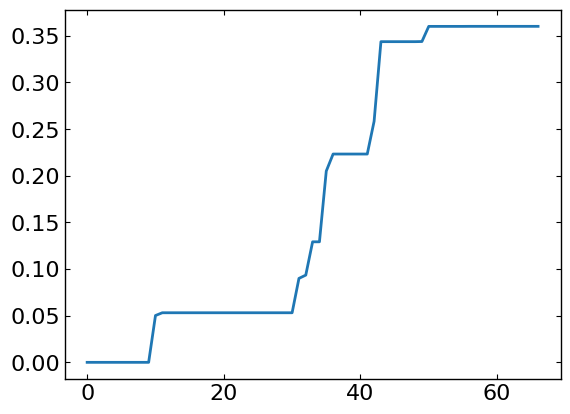

In [7]:
ax_client = optimizer.ax_client
pareto = ax_client.get_pareto_optimal_parameters(use_model_predictions=False)
best_keys = list(pareto.keys())
print(pareto)
plt.figure()
plt.plot(ax_client.get_trace())

#find max in get_trace
max_val = np.max(ax_client.get_trace())
index_max = np.argmax(ax_client.get_trace())
index_max = best_keys[0]
best_parameters = pareto[index_max][0]

hyst1.params_w(best_parameters,hyst1.params)
print(hyst1.get_SIMsalabim_clean_cmd(hyst1.params))
hyst1.package_SIMsalabim_files(hyst1.params,'zimt')

In [8]:
# plot the evolution of the optimization
render(ax_client.get_contour_plot(param_x="l2.mu_n", param_y="l2.mu_p", metric_name=optimizer.all_metrics[0]))

model = ax_client.generation_strategy.model

render(plot_slice(model=model, param_name="l2.mu_n", metric_name=optimizer.all_metrics[0]))
render(plot_slice(model=model, param_name="l2.mu_p", metric_name=optimizer.all_metrics[0]))
render(plot_slice(model=model, param_name="l2.N_ions", metric_name=optimizer.all_metrics[0]))
# render(plot_slice(model=model, param_name="l2.C_np_bulk", metric_name=metric))


[INFO 12-03 16:05:58] ax.service.ax_client: Retrieving contour plot with parameter 'l2.mu_n' on X-axis and 'l2.mu_p' on Y-axis, for metric 'Hyst1_JV_rmsre'. Remaining parameters are affixed to the middle of their range.


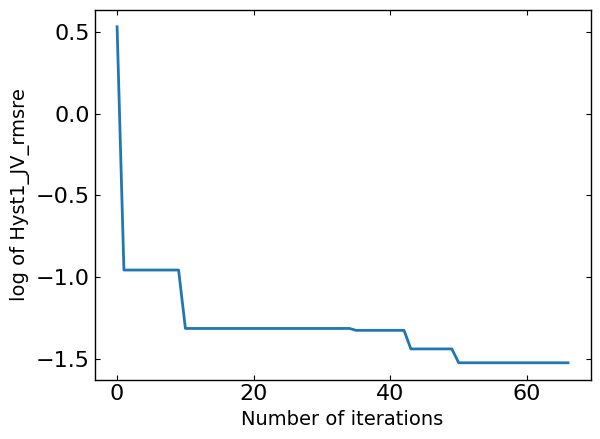

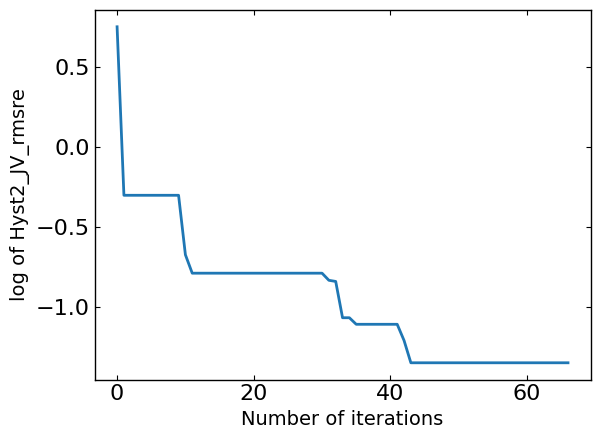

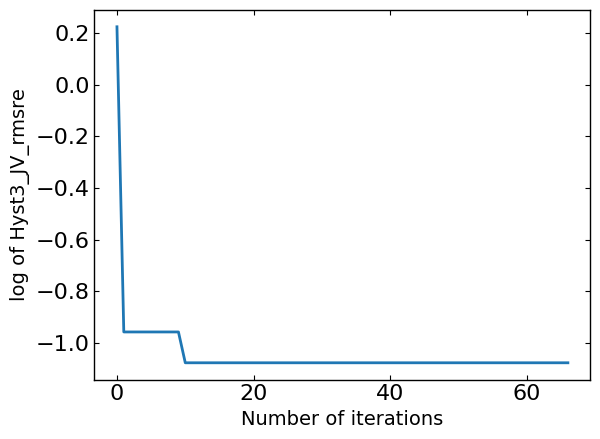

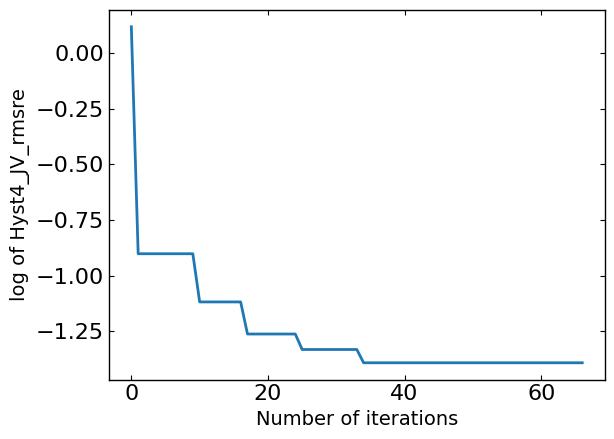

In [9]:
data = ax_client.experiment.fetch_data()
# split df by metric name 
data = data.df
metric1_df = data[data["metric_name"] == optimizer.all_metrics[0]]
metric2_df = data[data["metric_name"] == optimizer.all_metrics[1]]
metric3_df = data[data["metric_name"] == optimizer.all_metrics[2]]
metric4_df = data[data["metric_name"] == optimizer.all_metrics[3]]

# reset index
metric1_df = metric1_df.reset_index(drop=True)
metric2_df = metric2_df.reset_index(drop=True)
metric3_df = metric3_df.reset_index(drop=True)
metric4_df = metric4_df.reset_index(drop=True)
# plt.figure()
# plt.plot(np.minimum.accumulate(data.df["mean"]), label="Best value seen so far")

plt.figure()
plt.plot(np.minimum.accumulate(metric1_df["mean"]), label="Best value seen so far")
plt.xlabel('Number of iterations')
plt.ylabel('log of '+optimizer.all_metrics[0])

plt.figure()
plt.plot(np.minimum.accumulate(metric2_df["mean"]), label="Best value seen so far")
plt.xlabel('Number of iterations')
plt.ylabel('log of '+optimizer.all_metrics[1])

plt.figure()
plt.plot(np.minimum.accumulate(metric3_df["mean"]), label="Best value seen so far")
plt.xlabel('Number of iterations')
plt.ylabel('log of '+optimizer.all_metrics[2])

plt.figure()
plt.plot(np.minimum.accumulate(metric4_df["mean"]), label="Best value seen so far")
plt.xlabel('Number of iterations')
plt.ylabel('log of '+optimizer.all_metrics[3])


plt.show()

In [14]:
# create dic with keys same as ax_client.experiment.trials[0].arm.parameters
dumdic = {}
for key in ax_client.experiment.trials[0].arm.parameters.keys():
    dumdic[key] = []

# fill the dic with the values of the parameters
for i in range(len(ax_client.experiment.trials)):
    if ax_client.experiment.trials[i].status == T.COMPLETED:
        for key in ax_client.experiment.trials[i].arm.parameters.keys():
            dumdic[key].append(ax_client.experiment.trials[i].arm.parameters[key])


data = ax_client.experiment.fetch_data().df

target1 = data[data['metric_name'] == optimizer.all_metrics[0]]['mean']

dumdic[optimizer.all_metrics[0]] = list(target1)

target2 = data[data['metric_name'] ==  optimizer.all_metrics[1]]['mean']

dumdic[optimizer.all_metrics[1]] = list(target2)

target3 = data[data['metric_name'] ==  optimizer.all_metrics[2]]['mean']

dumdic[optimizer.all_metrics[2]] = list(target3)

target4 = data[data['metric_name'] ==  optimizer.all_metrics[3]]['mean']

dumdic[optimizer.all_metrics[3]] = list(target4)

dumdic['iteration'] = list(data[data['metric_name'] == optimizer.all_metrics[0]]['trial_index'])

df = pd.DataFrame(dumdic)

for par in params:
    if par.name in df.columns:
        if par.rescale:
            df[par.name] = df[par.name] *par.fscale


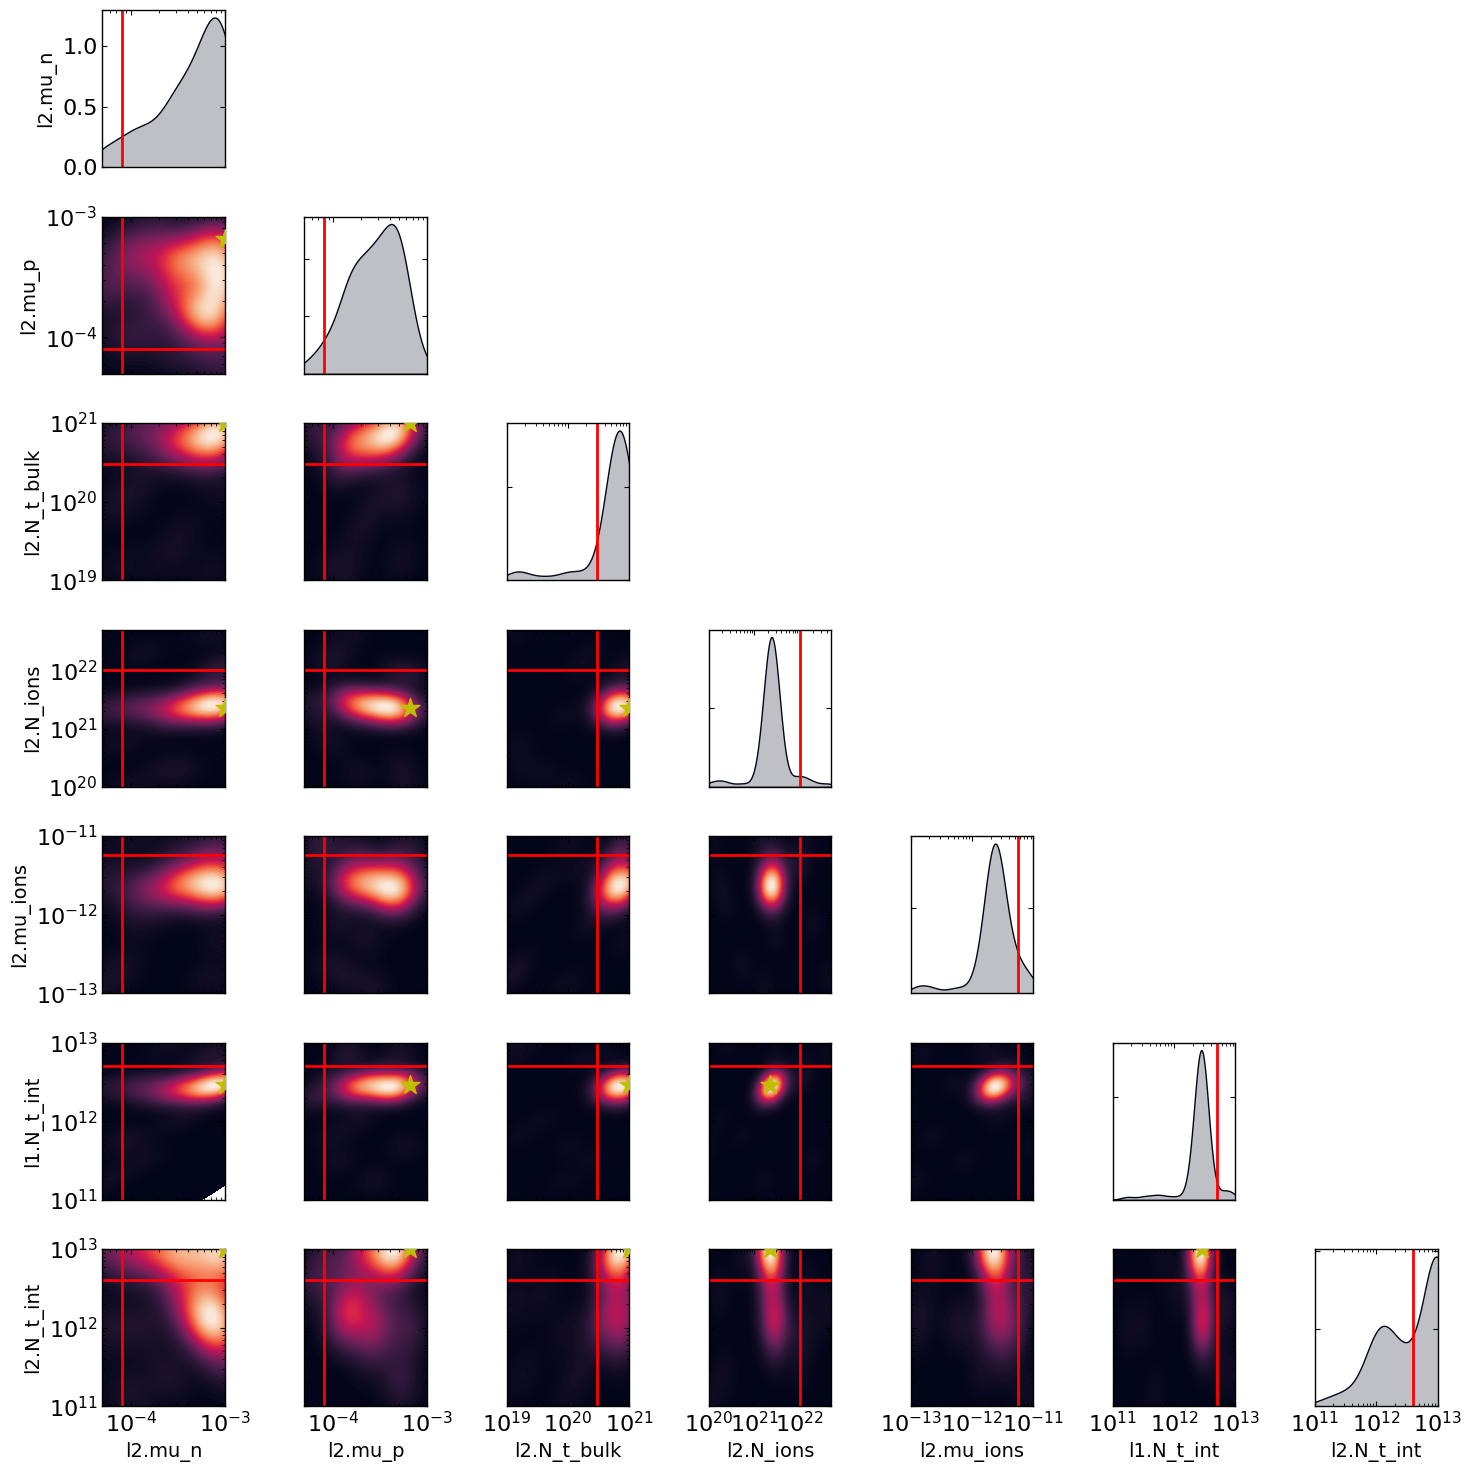

In [15]:
# get name of all parameters that are not 'fixed'
names = []
log_scale = []
axis_limits = []
for p in params:
    if p.type != 'fixed':
        names.append(p.name)
        log_scale.append(p.axis_type == 'log')
        axis_limits.append(p.bounds)


# Get all combinations of names
comb = list(combinations(names, 2))

# Determine the grid size
n = len(names)
fig, axes = plt.subplots(n, n, figsize=(15, 15))

# Plot each combination in the grid
for i, xx in enumerate(names):
    for j, yy in enumerate(names):
        xval = np.nan
        yval = np.nan

        for p in params_orig:
            if p.name == xx:
                xval = p.value
            if p.name == yy:
                yval = p.value

        ax = axes[i, j]
        if i == j:
            # kde plot on the diagonal
            sns.kdeplot(x=yy, data=df, ax=ax, fill=True, thresh=0, levels=100, cmap="rocket", color="#03051A", log_scale=log_scale[names.index(xx)])

            ax.axvline(x=yval, color='r', linestyle='-')
            # put point at the best value top of the axis
           

            if log_scale[names.index(yy)]:
                ax.set_xscale('log')
                ax.set_xlim(axis_limits[names.index(yy)])
            else:
                ax.set_xlim(axis_limits[names.index(yy)])
            
            # put x label on the top
            # except for the last one
            if i < n - 1:
                ax.xaxis.set_label_position('top')
                ax.xaxis.tick_top()

        elif i > j:
            kind = 'kde'
            if kind == 'scatter':
                sns.scatterplot(x=yy, y=xx, data=df, ax=ax, color="#03051A")
                ax.set_xscale('log')
                ax.set_yscale('log')
            else:
                sns.kdeplot(x=yy, y=xx, data=df, ax=ax, fill=True, thresh=0, levels=100, cmap="rocket", color="#03051A", log_scale=(log_scale[names.index(yy)], log_scale[names.index(xx)]))

            xval = np.nan
            yval = np.nan
            for p in params_orig:
                if p.name == xx:
                    xval = p.value
                elif p.name == yy:
                    yval = p.value

            # Plot as line over the full axis
            ax.axhline(y=xval, color='r', linestyle='-')
            ax.axvline(x=yval, color='r', linestyle='-')
            ax.scatter(best_parameters[yy], best_parameters[xx], c='y', marker='*', s=200, zorder=10)
            
            ax.set_xlim(axis_limits[names.index(yy)])
            ax.set_ylim(axis_limits[names.index(xx)])
        else:
            ax.set_visible(False)

        if j > 0:
            ax.set_yticklabels([])
            # remove the y axis label
            ax.set_ylabel('')
        if i < n - 1:
            ax.set_xticklabels([])
            # remove the x axis label
            ax.set_xlabel('')

        if i == n - 1:
            ax.set_xlabel(yy)
        if j == 0:
            ax.set_ylabel(xx)

plt.tight_layout()
plt.show()

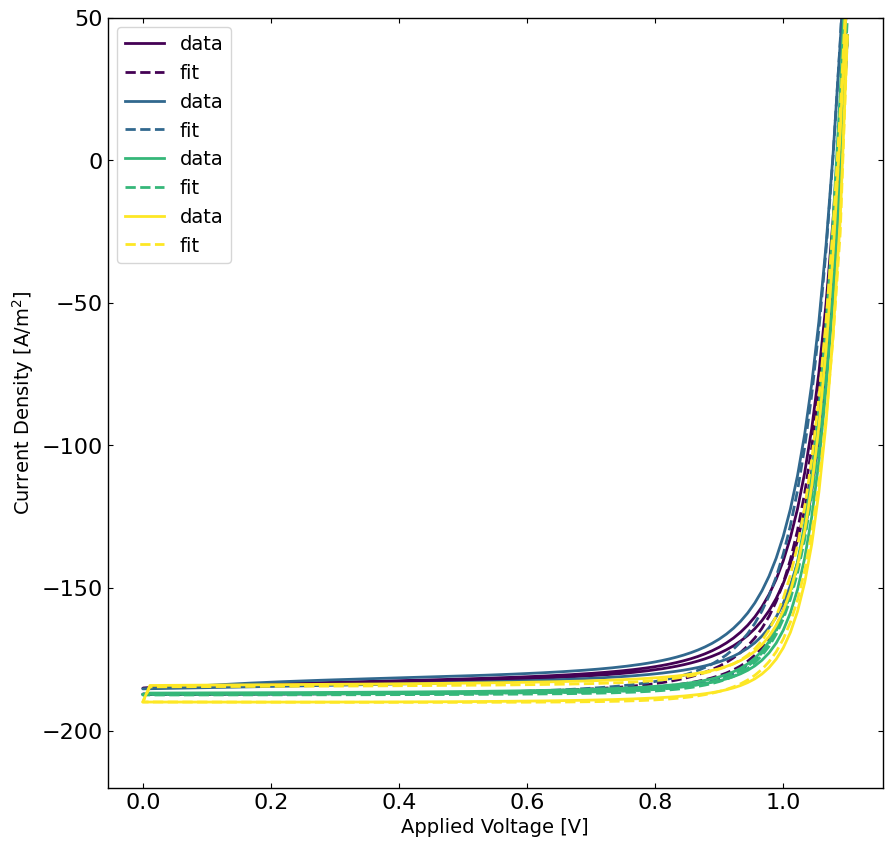

In [16]:
# rerun the simulation with the best parameters
plt.figure(figsize=(10,10))
viridis = plt.cm.get_cmap('viridis', 4)
plt.plot(-hyst1.X[0],-hyst1.y[0],label='data',color=viridis(0))
plt.plot(-hyst1.X[0],-hyst1.run(parameters=best_parameters,exp_format='JV'),label='fit',linestyle='--',color=viridis(0))

plt.plot(-hyst2.X[0],-hyst2.y[0],label='data',color=viridis(1))
plt.plot(-hyst2.X[0],-hyst2.run(parameters=best_parameters,exp_format='JV'),label='fit',linestyle='--',color=viridis(1))

plt.plot(-hyst3.X[0],-hyst3.y[0],label='data',color=viridis(2))
plt.plot(-hyst3.X[0],-hyst3.run(parameters=best_parameters,exp_format='JV'),label='fit',linestyle='--',color=viridis(2))

plt.plot(-hyst4.X[0],-hyst4.y[0],label='data',color=viridis(3))
plt.plot(-hyst4.X[0],-hyst4.run(parameters=best_parameters,exp_format='JV'),label='fit',linestyle='--',color=viridis(3))

plt.xlabel('Applied Voltage [V]')
plt.ylabel('Current Density [A/m$^2$]')
plt.ylim(-220,50)
plt.legend()
plt.show()

In [13]:
# Clean up the output files (comment out if you want to keep the output files)
sim.clean_all_output(session_path_zimt)
sim.delete_folders('tmp',session_path_zimt)